<a href="https://www.kaggle.com/code/duaanaz/face-recognition?scriptVersionId=251835309" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# *Face Recognition Project*

In [7]:
# Load important libraries
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set the plotting style
plt.style.use('ggplot')


In [8]:
# Load pre-trained Haar Cascade classifiers for face, eyes, smile, and nose detection

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")
# nose_cascade = cv2.CascadeClassifier(os.path.expanduser("~/haarcascade_mcs_nose.xml"))


In [9]:
base_path = '../input/students-images/'
student_ids= sorted(os.listdir(base_path))

# EDA
**Data Frame**

In [12]:
# Make data frame
df = []
for std_id in student_ids:
    paths = sorted(glob(os.path.join(base_path,std_id,std_id,'*.jpg'))) 
    for p in paths:
        img = cv2.imread(p)
        if img is None:
            print("there is no image")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        df.append({
            'student_id': std_id,
            'path': p,
            'height': img.shape[0],
            'width': img.shape[1],
            'aspect_ratio': img.shape[1] / img.shape[0],
            'brightness': np.mean(gray),
            'contrast': np.std(gray),
            'blur_score': cv2.Laplacian(gray, cv2.CV_64F).var()
        })

# Convert the list to a DataFrame
df = pd.DataFrame(df)

# print data frame
print(df)


     student_id                                            path  height  \
0            01  ../input/students-images/01/01/frame_00000.jpg    1280   
1            01  ../input/students-images/01/01/frame_00001.jpg    1280   
2            01  ../input/students-images/01/01/frame_00002.jpg    1280   
3            01  ../input/students-images/01/01/frame_00003.jpg    1280   
4            01  ../input/students-images/01/01/frame_00004.jpg    1280   
...         ...                                             ...     ...   
3831         11  ../input/students-images/11/11/frame_00309.jpg    1280   
3832         11  ../input/students-images/11/11/frame_00310.jpg    1280   
3833         11  ../input/students-images/11/11/frame_00311.jpg    1280   
3834         11  ../input/students-images/11/11/frame_00312.jpg    1280   
3835         11  ../input/students-images/11/11/frame_00313.jpg    1280   

      width  aspect_ratio  brightness   contrast  blur_score  
0       720        0.5625  126.00658

# *Face Detection and Cropping with Grayscale Conversion*

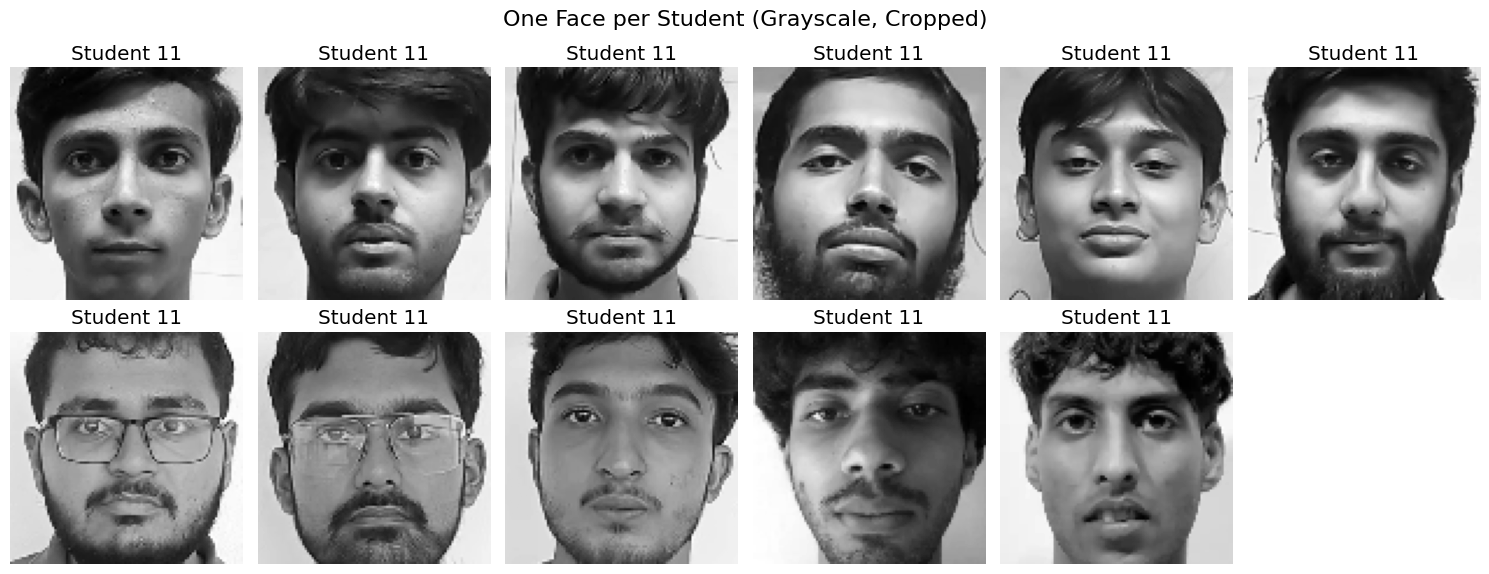

In [13]:
# Visualize 1 face per student
plt.figure(figsize=(15, 6))

for i, sid in enumerate(sorted(df['student_id'].unique())):
    # Get first image path for each student
    sample_row = df[df['student_id'] == sid].iloc[0]
    path = sample_row['path']
    
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to Grayscale
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    # Try detecting face
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (100, 100))
    else:
        face = cv2.resize(gray, (100, 100))  # fallback

    # Show extracted face
    plt.subplot(2, 6, i+1)
    plt.imshow(face,cmap='gray')
    plt.title(f"Student {std_id}")
    plt.axis('off')

plt.suptitle("One Face per Student (Grayscale, Cropped)", fontsize=16)
plt.tight_layout()
plt.show()

# Face Detection Coverage

In [ ]:
detected_faces = 0
for p in df['path']:
    img = cv2.imread(p)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        detected_faces += 1

print(f"Faces Detected: {detected_faces} / {len(df)}")

In [ ]:
# pie chart
plt.pie([detected_faces, len(df)-detected_faces], 
        labels=["Detected", "Not Detected"], 
        autopct='%1.1f%%', colors=['green', 'red'])
plt.title("Face Detection Coverage")
plt.show()

# Assessing Data Quantity

Number of images per student:
student_id
01    368
02    312
03    310
04    342
05    295
06    274
07    512
08    382
09    318
10    441
11    282
Name: count, dtype: int64


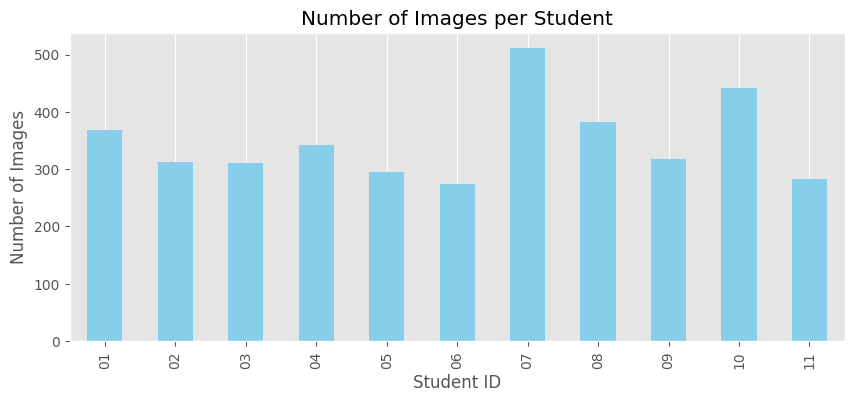

In [14]:
# Print number of images per student
print("Number of images per student:")
print(df['student_id'].value_counts().sort_index())

# Visualizations of: 
# No. of Images per student 
plt.figure(figsize=(10, 4))
df['student_id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of Images per Student")
plt.xlabel("Student ID")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

# Image Quality Analysis
# Aspect Ratio Insight

<Figure size 1000x400 with 0 Axes>

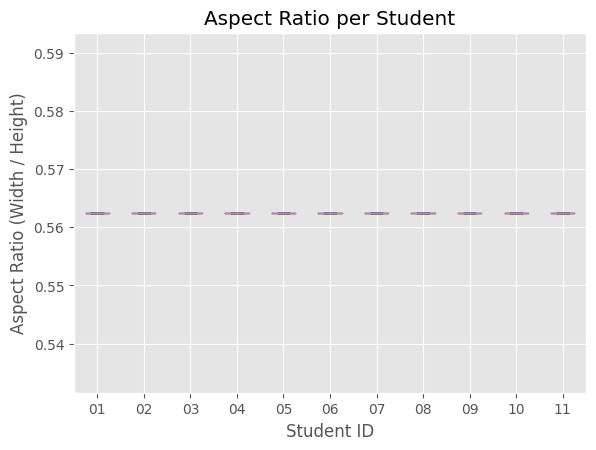

In [16]:
# Aspect Ratio per image
plt.figure(figsize=(10, 4))
df.boxplot(column='aspect_ratio', by='student_id')
plt.title("Aspect Ratio per Student")
plt.suptitle("")
plt.xlabel("Student ID")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.grid(True)
plt.show()

# Bright vs Contrast Insight

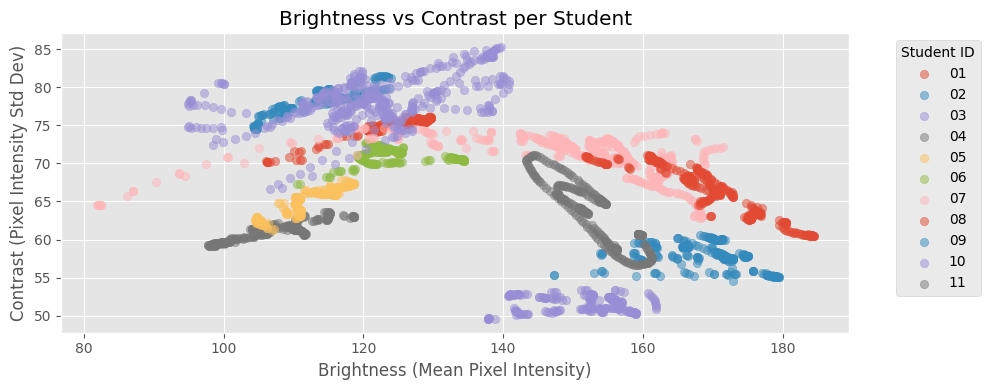

In [20]:
# Brightness vs Contrast
plt.figure(figsize=(10, 4))
for std_id in sorted(df['student_id'].unique()):
    sub = df[df['student_id'] == std_id]
    plt.scatter(sub['brightness'], sub['contrast'], label=std_id, alpha=0.5)

plt.xlabel("Brightness (Mean Pixel Intensity)")
plt.ylabel("Contrast (Pixel Intensity Std Dev)")
plt.title("Brightness vs Contrast per Student")
plt.legend(title="Student ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sharpness of the Image

<Figure size 1000x400 with 0 Axes>

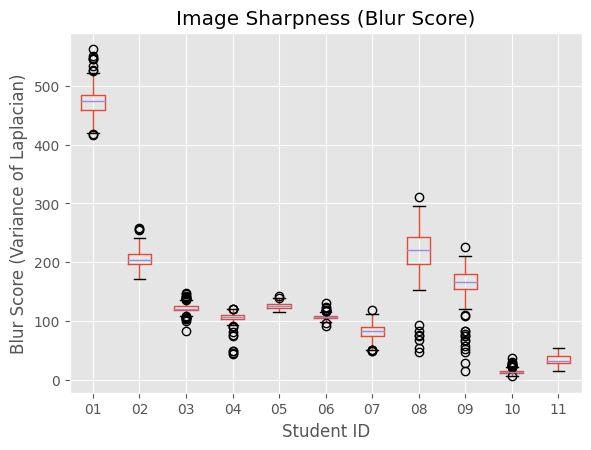

In [17]:
# Blur Score of Images
plt.figure(figsize=(10, 4))
df.boxplot(column='blur_score', by='student_id')
plt.title("Image Sharpness (Blur Score)")
plt.suptitle("")
plt.xlabel("Student ID")
plt.ylabel("Blur Score (Variance of Laplacian)")
plt.grid(True)
plt.show()

# Size Distribution

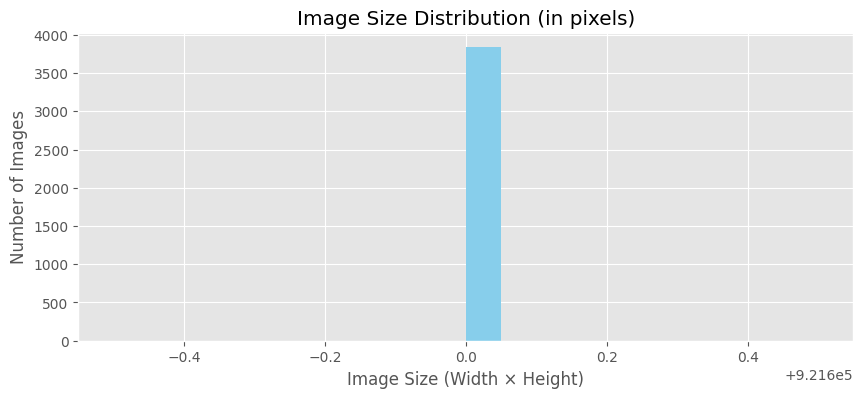

In [18]:
# Image size distribution
plt.figure(figsize=(10, 4))
plt.hist(df['width'] * df['height'], bins=20, color='skyblue')
plt.title("Image Size Distribution (in pixels)")
plt.xlabel("Image Size (Width × Height)")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()



# Feature Extraction: HOG

In [ ]:
# --- HOG Visualization ---
print("\nHOG Visualization Example:")

# Pick one example face
sample_path = df.iloc[0]['path']
img = cv2.imread(sample_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = cv2.resize(gray, (100, 100)

# Extract HOG features and image
features, hog_image = hog(face, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, feature_vector=True)
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# original image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(face, cmap='gray')
plt.title("Face")
plt.axis('off')

# hog image
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")
plt.axis('off')
plt.show()

In [ ]:
# Model training
X_train, X_test, y_train, y_test = [], [], [], []
le = LabelEncoder()

print("Extracting HOG features...")
for sid in student_ids:
    feats = []
    paths = sorted(glob(os.path.join(base, sid,sid, '*.jpg')))
    for p in paths:
        img = cv2.imread(p)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        if len(faces) == 0:
            continue
        x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
        face = gray[y:y + h, x:x + w]
        if np.var(face) < 100:
            continue
        face = cv2.resize(face, (100, 100)).astype('float32') / 255.0
        feats.append(hog(face, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True))
    
    if len(feats) >= 2:
        a, b = train_test_split(feats, test_size=0.5, random_state=42)
        X_train += a
        X_test += b
        y_train += [sid] * len(a)
        y_test += [sid] * len(b)

# Encode the labels
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Training SVM...")
model = SVC(kernel='linear', probability=True).fit(X_train, y_train_enc)
print("Training complete.")

# --- Evaluation ---
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test_enc, y_pred), display_labels=le.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# --- Real-Time Webcam Recognition ---
# Not implemented succcessfuly yet -- just a sample code
# Webcame is not accessible
def run_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Webcam not accessible.")
        return
    print("Press 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y + h, x:x + w]
            roi_color = frame[y:y + h, x:x + w]
            if np.var(roi_gray) < 100:
                continue
            
            face_resized = cv2.resize(roi_gray, (100, 100)).astype('float32') / 255.0
            feat = hog(face_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True).reshape(1, -1)
            pred = model.predict(feat)[0]
            prob = model.predict_proba(feat).max()
            label = le.inverse_transform([pred])[0] if prob > 0.85 else "Unknown"
            color = (0, 255, 0) if prob > 0.85 else (0, 0, 255)
            
            # Draw rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} ({prob * 100:.1f}%)", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

             # Features inside face only
            face_gray = roi_gray
            face_col = roi_color

            # Detect eyes
            eyes = eye_cascade.detectMultiScale(face_gray, 1.1, 10)
            eyes_filtered = [e for e in eyes if e[1] < h // 2]
            for (ex, ey, ew, eh) in eyes_filtered[:2]:
                cv2.rectangle(face_col, (ex, ey), (ex + ew, ey + eh), (255, 0, 0), 1)

            # Detect nose
            noses = nose_cascade.detectMultiScale(face_gray, 1.1, 10)
            if len(noses):
                nx, ny, nw, nh = min(noses, key=lambda r: abs(r[1] - h // 2))
                cv2.rectangle(face_col, (nx, ny), (nx + nw, ny + nh), (0, 255, 255), 1)

            # Detect smile
            smiles = smile_cascade.detectMultiScale(face_gray, 1.1, 25)
            smiles_filtered = [s for s in smiles if s[1] > h // 2]
            if len(smiles_filtered):
                sx, sy, sw, sh = max(smiles_filtered, key=lambda r: r[2] * r[3])
                cv2.rectangle(face_col, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 1)

        # Display the frame
        cv2.imshow("Webcam Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

# Run the webcam recognition
run_webcam()